In [3]:
import os
import glob
import cv2
import numpy as np
from concurrent import futures
import threading

# set cell_images folder path for dataset
root ="Malaria_dataset/cell_images"

# read dataset
base_dir = os.path.join(root)
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13779, 13779)

In [4]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,Malaria_dataset/cell_images\Parasitized\C130P9...,malaria
1,Malaria_dataset/cell_images\Parasitized\C188P1...,malaria
2,Malaria_dataset/cell_images\Uninfected\C173P13...,healthy
3,Malaria_dataset/cell_images\Uninfected\C78P39T...,healthy
4,Malaria_dataset/cell_images\Uninfected\C107P68...,healthy


In [5]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(17361,) (1929,) (8268,)
Train: Counter({'healthy': 8734, 'malaria': 8627}) 
Val: Counter({'healthy': 970, 'malaria': 959}) 
Test: Counter({'malaria': 4193, 'healthy': 4075})


In [6]:
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    # Apply bilateral filter with d = 15,  
    # sigmaColor = sigmaSpace = 75.
    img = cv2.bilateralFilter(img, 3,7, 9) 
    img = cv2.resize(img, dsize=IMG_DIMS, interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape

Loading Train Images:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_2: working on img num: 5000
ThreadPoolExecutor-0_4: working on img num: 10000
ThreadPoolExecutor-0_10: working on img num: 15000
ThreadPoolExecutor-0_4: working on img num: 17360

Loading Validation Images:
ThreadPoolExecutor-0_9: working on img num: 0
ThreadPoolExecutor-0_7: working on img num: 1928

Loading Test Images:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_10: working on img num: 5000
ThreadPoolExecutor-0_9: working on img num: 8267


((17361, 125, 125, 3), (1929, 125, 125, 3), (8268, 125, 125, 3))

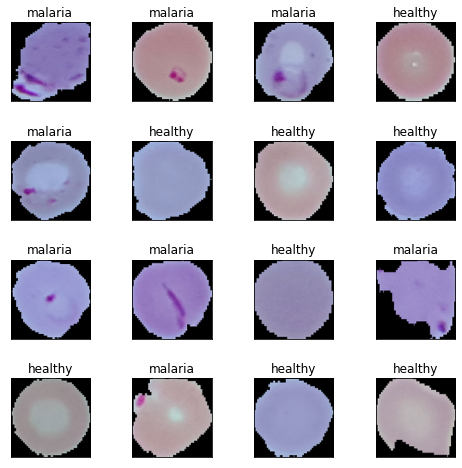

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [8]:
BATCH_SIZE = 512
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

# change version of tensorflow
#%tensorflow_version 2.x
print(train_labels[:6], train_labels_enc[:6])

['malaria' 'malaria' 'malaria' 'healthy' 'healthy' 'malaria'] [1 1 1 0 0 1]


In [9]:
import tensorflow as tf

# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

#tf.random.set_random_seed(42)
tf.random.set_seed(42)
tf.__version__

'2.9.1'

CNN

In [10]:
#Model Architecture
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 125, 125, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 125, 125, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 128)       73856 

In [25]:
# Train model
history = model.fit(train_imgs_scaled, train_labels_enc, validation_data=(val_imgs_scaled,val_labels_enc), epochs=25,
    batch_size=512 )

Epoch 1/25
34/34 [==============================] - 275s 8s/step - loss: 0.7373 - accuracy: 0.5307 - val_loss: 0.6898 - val_accuracy: 0.5241
Epoch 2/25
15/34 [============>.................] - ETA: 2:37 - loss: 0.6705 - accuracy: 0.6161

KeyboardInterrupt: 

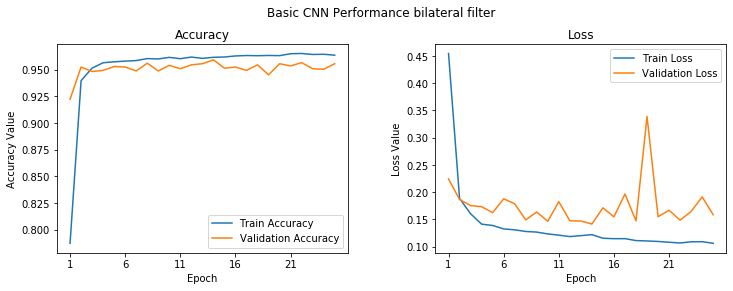

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance of CNN', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.save('malaria_detector_cnn.h5')

Evaluation of Models

In [11]:
#scale test data
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((8268, 125, 125, 3), (8268,))

In [12]:
# Load Saved CNN Model
cnn = tf.keras.models.load_model('malaria_detector_cnn.h5')

# Make Predictions on Test Data
cnn_preds = cnn.predict(test_imgs_scaled, batch_size=512)

cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in cnn_preds.ravel()])

17/17 [==============================] - 19s 1s/step


In [13]:
import model_evaluation_utils as meu
import pandas as pd

cnn_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=cnn_pred_labels)

pd.DataFrame([ cnn_metrics ], 
             index=['CNN'])

,Accuracy,Precision,Recall,Sensitivity,specificity,F1 Score
CNN,97.0972,97.1148,97.0972,96.1714,98.0316,97.0974


In [20]:
from keras.models import load_model
import cv2
import numpy as np

model = load_model('malaria_detector_cnn.h5')

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

img = cv2.imread('Malaria_img.png')
img = img / 255.
img = cv2.resize(img,(125,125))
img = np.reshape(img,[1,125,125,3])

print("--------- Predictive Model of Malaria Detection----------\n")

pred = model.predict(img)
print("Results:")
"Malaria-infected" if pred > 0.5 else "Un-infected"

--------- Predictive Model of Malaria Detection----------

1/1 [==============================] - 0s 98ms/step
Results:


'Malaria-infected'

In [23]:
model = load_model('malaria_detector_cnn.h5')

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

img = cv2.imread('non-malaria.png')
img = img / 255.
img = cv2.resize(img,(125,125))
img = np.reshape(img,[1,125,125,3])

print("--------- Predictive Model of Malaria Detection----------\n")

pred = model.predict(img)
print("Results:")
"Malaria-infected" if pred > 0.5 else "Un-infected"

--------- Predictive Model of Malaria Detection----------

1/1 [==============================] - 0s 94ms/step
Results:


'Un-infected'